### Main imports and GPU settings

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import matplotlib.pyplot as plt


# Show all available GPUs
print(torch.cuda.get_device_name(0))

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('=======================\n')
GPU = False
# Set default tensor type to cuda.FloatTensor if GPU is available
if torch.cuda.is_available() and GPU:
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device(device)
    torch.set_default_dtype(torch.float32)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Dtype: {torch.get_default_dtype()}")
    print(f"Device: {torch.cuda.current_device()}")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = torch.device("cpu")
    torch.set_default_device(device)
    print("Using CPU")


# Set seed for reproducibility
torch.manual_seed(0)

NVIDIA GeForce RTX 2060
cuda:0

Using CPU


### Local imports of classes

In [38]:
import random
import importlib

# Local imports modules
import classes.SimulationNN as SimulationNN
import classes.Systems as Systems
import classes.PID as PID

# Reload modules
importlib.reload(SimulationNN)
importlib.reload(Systems)
importlib.reload(PID)

# Local import reloaded classes
from classes.SimulationNN import SimulationNN
from classes.Systems import Trolley
from classes.PID import PID

### Build Neural Network and CustomLoss function

In [39]:
# Defining the architecture of the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, 6)
        self.fc3 = nn.Linear(6, 3)

        # Activation functions
        self.act_tahn = nn.Tanh()
        self.act_softplus = nn.Softplus()
        self.act_relu = nn.ReLU()
        self.act_relu6 = nn.ReLU6()

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

        # Initialize biases
        self.fc1.bias.data.fill_(0.01)
        self.fc2.bias.data.fill_(0.01)
        # self.fc3.bias.data.fill_(0.01)

    def forward(self, x) -> Tensor:
        x = self.fc1(x)
        x = self.act_relu6(x)
        x = self.fc2(x)
        x = self.act_relu6(x)
        x = self.fc3(x)
        return x


# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, vector_K: Tensor, vector_E: Tensor, dt: Tensor):
        """
        Args:
            vector_K (tensor): [Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1] vector of the gains
            vector_E (tensor): [E_t, E_t_1] vector of the errors
            dt (float): time step between the current and previous position

        Returns:
            loss (tensor): loss function
        """
        # Unpack the vectors
        Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1 = vector_K

        E_t, E_t_1 = vector_E


        # Compute
        dKp = Kp_t - Kp_t_1
        dKi = Ki_t - Ki_t_1
        dKd = Kd_t - Kd_t_1

        # Clamp the values
        dKp = torch.clamp(dKp, min=1e-1, max=1e6)
        dKi = torch.clamp(dKi, min=1e-1, max=1e6)
        dKd = torch.clamp(dKd, min=1e-1, max=1e6)

        
        dEdKp = (E_t - E_t_1) / dKp
        dEdKi = (E_t - E_t_1) / dKi
        dEdKd = (E_t - E_t_1) / dKd

        # Compute the loss function
        loss_Kp = torch.mean(dEdKp**2)
        loss_Ki = torch.mean(dEdKi**2)
        loss_Kd = torch.mean(dEdKd**2)

        # Compute the total loss
        loss = loss_Kp + loss_Ki + loss_Kd          
        

        loss = torch.mean(E_t)
        return loss


### Creating the model, loss function and optimizer

In [40]:
# Model
model = NeuralNetwork()

# Loss function
custom_loss = CustomLoss()

# Optimizers
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.09)
# optimizer = optim.Adam(model.parameters(), lr = torch.tensor(0.0001))

In [41]:

DT = torch.tensor(0.02)
TIME = torch.arange(0, 120, DT)
TARGET = 5 * torch.ones(len(TIME))
DISTURBANCE = torch.zeros(len(TIME))

mass = torch.tensor(1)
friction = torch.tensor(0.1)
trolley = Trolley(mass=mass, friction=friction, dt=DT)

KP = torch.tensor(1)
KI = torch.tensor(0.1)
KD = torch.tensor(0.5)
pid = PID(KP, KI, KD)
pid.setLims(None, None)

simulation = SimulationNN(TIME, TARGET, DISTURBANCE, DT)
simulation.model = model
simulation.custom_loss = custom_loss
simulation.optimizer = optimizer

In [42]:
EPOCHS = 1
for i in range(EPOCHS):
    # Reset the trolley and simulation
    trolley.reset()
    simulation.reset()    

    print(f"-----------------Epoch {i+1}/{EPOCHS}-----------------")
    
    # TARGET = torch.ones(len(TIME)) * random.uniform(0, 10)
    # TARGET[TIME > 30] = random.uniform(0, 10)
    # TARGET[TIME > 60] = random.uniform(0, 10)
    # TARGET[TIME > 90] = random.uniform(0, 10)
    # TARGET[TIME > 160] = random.uniform(0, 10)
        
    # trolley.mass = torch.tensor(random.uniform(0.5, 3))
    # trolley.friction = torch.tensor(random.uniform(0.01, 0.5))
    # trolley.spring_constant = torch.tensor(random.uniform(0, 100))

    # simulation.target = TARGET
    simulation.run(trolley, pid)

-----------------Epoch 1/1-----------------


  0%|          | 0/6000 [00:00<?, ?it/s]

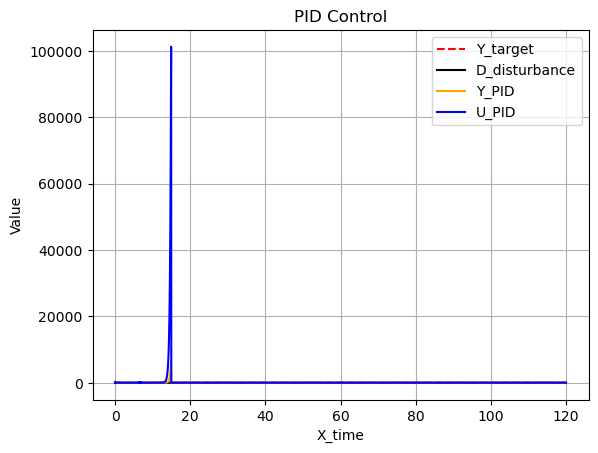

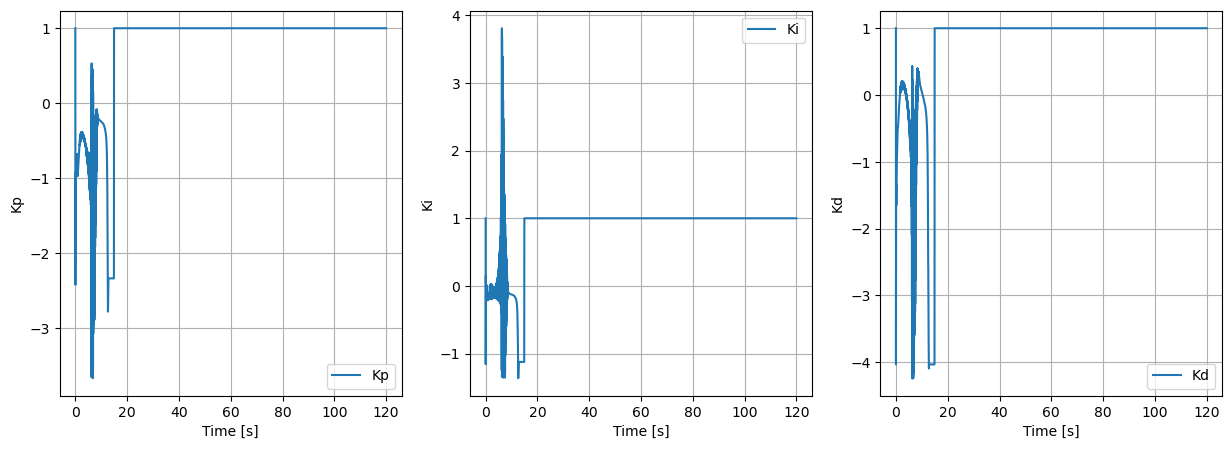

In [46]:
simulation.plot()
simulation.plot_K()

In [47]:
print(simulation.feedback_E[:10])
print(simulation.feedback_L[:10])
print(simulation.feedback_Kp[:10])
print(simulation.feedback_Ki[:10])
print(simulation.feedback_Kd[:10])


tensor([0.0000, 4.8980, 4.7946, 4.6919, 4.5912, 4.4923, 4.3945, 4.2976, 4.2014,
        4.1059], grad_fn=<SliceBackward0>)
tensor([0.0000, 4.8980, 4.7946, 4.6919, 4.5912, 4.4923, 4.3945, 4.2976, 4.2014,
        4.1059], grad_fn=<SliceBackward0>)
tensor([ 1.0000, -2.3328, -2.4183, -1.7878, -1.2487, -0.9865, -0.9199, -0.9723,
        -1.0387, -1.0703], grad_fn=<SliceBackward0>)
tensor([ 1.0000, -1.1226, -1.1564, -0.4284,  0.0891,  0.1517,  0.0766, -0.0050,
        -0.0614, -0.0815], grad_fn=<SliceBackward0>)
tensor([ 1.0000, -4.0321, -3.0718, -1.8138, -1.3308, -1.4115, -1.4865, -1.5962,
        -1.6504, -1.6250], grad_fn=<SliceBackward0>)


In [45]:
# Save the model
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully")       

Model saved successfully
